#

Python and web scrapping 

#
- for facial analysis, we use cv lib and try to identify the eyes, if the eyes are visible, we keep them, else, we discard it. We then do a manual check to get rid of unwanted faces coming up as well. The cleaned images are then converted to wavelet transformed and then create the model.


- Use HAAR Cascade to detect faces. Uses line and edge features to create a moving window to map the face

- Wavelet transformation is used for feature extraction to extract important features from image

In [29]:
#!pip install PyWavelets
#!pip install opencv-python
#!pip install seaborn

In [169]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import shutil
import os
import pywt
from sklearn.svm import SVC #classification, best
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
import seaborn as sns
import joblib
import json

In [31]:
img=cv2.imread('./test_images/sharapova1.jpg')
img.shape

(555, 700, 3)

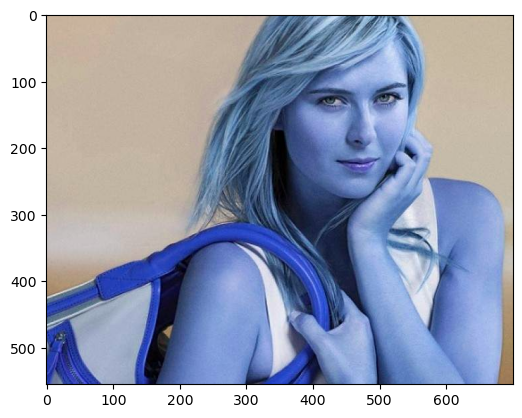

In [32]:
plt.imshow(img)

In [33]:
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray.shape

(555, 700)

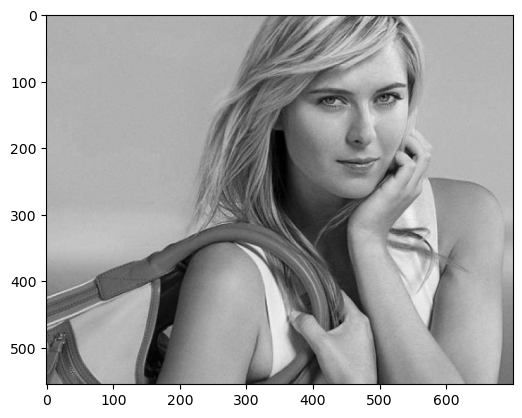

In [34]:
plt.imshow(gray,cmap='gray')

In [35]:
face_cascade= cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_default.xml')

eye_cascade= cv2.CascadeClassifier('./haarcascades/haarcascade_eye.xml')

faces=face_cascade.detectMultiScale(gray,1.3,5)

faces #returns multiple arrays if multiple faces, has x,y,width and height of face


array([[352,  38, 233, 233]], dtype=int32)

In [36]:
(x,y,w,h)=faces[0]
x,y,w,h

(np.int32(352), np.int32(38), np.int32(233), np.int32(233))

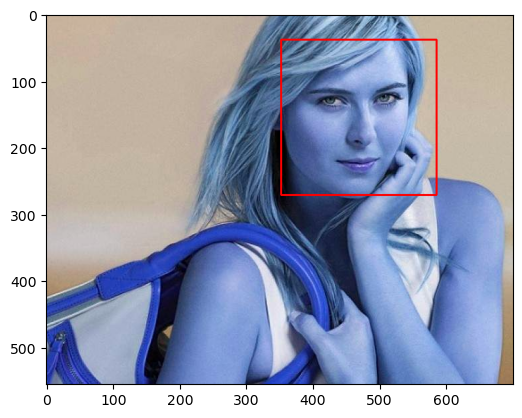

In [37]:
face_img=cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)#draws red rectangle

plt.imshow(face_img)

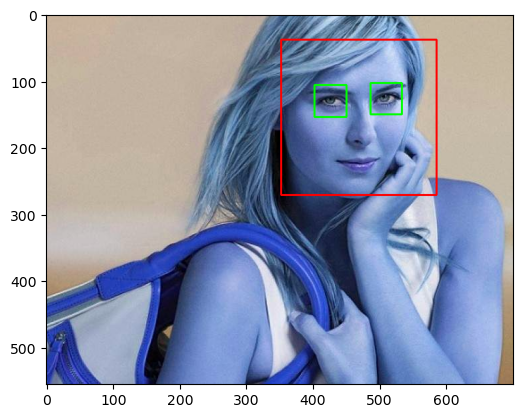

In [38]:
cv2.destroyAllWindows()

for (x,y,w,h) in faces:
    facface_img=cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)#draws red rectangle_img
    roi_gray=gray[y:y+h,x:x+w]
    roi_color=face_img[y:y+h,x:x+w]
    eyes=eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)


plt.figure()
plt.imshow(face_img,cmap='gray')
plt.show()

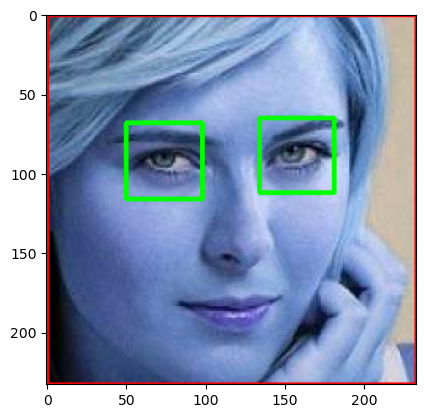

In [39]:
plt.imshow(roi_color,cmap='gray') #region of interest(roi)

In [40]:
def get_cropped_image_if_2_eyes(image_path):
    img=cv2.imread(image_path)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_cascade.detectMultiScale(gray,1.3,5)
    for (x,y,w,h) in faces:
        roi_gray=gray[y:y+h,x:x+w]
        roi_color=img[y:y+h,x:x+w]
        eyes=eye_cascade.detectMultiScale(roi_gray)
        if len(eyes)>=2:
            return roi_color
                 
#add code to handle more than 1 img
cropped_image=get_cropped_image_if_2_eyes('./test_images/sharapova1.jpg')

In [41]:
path_to_data='./images_dataset'
path_to_cr_data='./cropped_dataset'

img_dirs=[]

for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [42]:
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)

os.mkdir(path_to_cr_data)

In [43]:
celebrity_file_names_dict={}
cropped_images_dirs=[]
for img_dir in img_dirs:
    count=1
    celebrity_name=img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name]=[]
    for entry in os.scandir(img_dir):
        roi_color=get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder=path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.mkdir(cropped_folder)
                cropped_images_dirs.append(cropped_folder)
                print("Creating my cropped folder: ", cropped_folder)
            cropped_file_name=celebrity_name+str(count)+'.png'
            cropped_file_path=cropped_folder+'/'+cropped_file_name
            cv2.imwrite(cropped_file_path,roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count+=1

In [149]:
def w2d(img,mode='haar',level=1):
    imarray=img
    imarray=cv2.cvtColor(imarray,cv2.COLOR_RGB2GRAY)#datatype conversion to grayscale
    imarray=np.float32(imarray)# convert to float
    imarray/=255
    coeff=pywt.wavedec2(imarray,mode,level=level)#computing coefficients
    coeff_h=list(coeff)#processing coefficients
    coeff_h[0]*=0
    imarray_h=pywt.waverec2(coeff_h,mode)#reconstruction
    imarray_h*=255
    imarray_h=np.uint8(imarray_h)
    return imarray_h


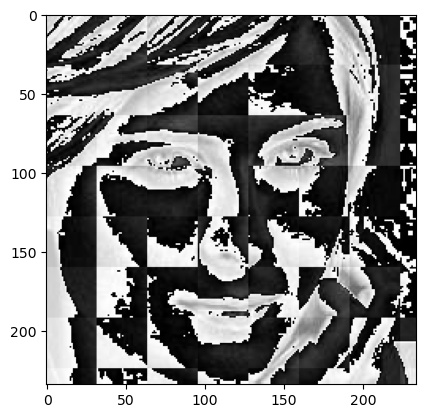

In [150]:
im_har=w2d(cropped_image,'db1',5)
plt.imshow(im_har,cmap='gray')

In [151]:
class_dict={}
count=0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name]=count
    count+=1
class_dict

{'maria_sharapova': 0,
 'virat_kohli': 1,
 'lionel_messi': 2,
 'serena_williams': 3,
 'roger_federer': 4}

In [152]:
X=[]
y=[]
for celebrity_name,training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img=cv2.imread(training_image)
        if img is None:
            continue
        scaled_raw_img=cv2.resize(img,(32,32))
        img_har=w2d(img,'db1',5)
        scaled_img_har=cv2.resize(img_har,(32,32))
        combined_img=np.vstack((scaled_raw_img.reshape(32*32*3,1),scaled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

[ WARN:0@4991.870] global loadsave.cpp:275 findDecoder imread_('./cropped_datasetmaria_sharapova/maria_sharapova8.png'): can't open/read file: check file path/integrity
[ WARN:0@4991.879] global loadsave.cpp:275 findDecoder imread_('./cropped_datasetmaria_sharapova/maria_sharapova13.png'): can't open/read file: check file path/integrity
[ WARN:0@4991.903] global loadsave.cpp:275 findDecoder imread_('./cropped_datasetmaria_sharapova/maria_sharapova21.png'): can't open/read file: check file path/integrity
[ WARN:0@4991.915] global loadsave.cpp:275 findDecoder imread_('./cropped_datasetmaria_sharapova/maria_sharapova26.png'): can't open/read file: check file path/integrity
[ WARN:0@4991.915] global loadsave.cpp:275 findDecoder imread_('./cropped_datasetmaria_sharapova/maria_sharapova27.png'): can't open/read file: check file path/integrity
[ WARN:0@4991.915] global loadsave.cpp:275 findDecoder imread_('./cropped_datasetmaria_sharapova/maria_sharapova28.png'): can't open/read file: check f

In [153]:
len(X[0]) #32*32*3 + 32*32

4096

In [154]:
len(y)

155

In [155]:
X=np.array(X).reshape(len(X),4096).astype(float) # to avoid warning during model, we convert to float

In [156]:
X[0]

array([173., 174., 174., ..., 253., 233., 252.])

In [157]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0)

pipe=Pipeline([('scaler',StandardScaler()),('svc',SVC(kernel='rbf',C=10))])

pipe.fit(X_train,y_train)

pipe.score(X_test,y_test)

0.7692307692307693

In [158]:
print(classification_report(y_test,pipe.predict(X_test)))

#Precision= how precise and accurate the model predicts
#Recall=how many of the relevant items were selected(how many predictable)
#F1-score= Score using precision and recall

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.73      1.00      0.84         8
           2       0.78      0.64      0.70        11
           3       1.00      0.67      0.80         6
           4       0.50      0.67      0.57         6

    accuracy                           0.77        39
   macro avg       0.80      0.77      0.77        39
weighted avg       0.80      0.77      0.77        39



In [159]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto',probability=True),
        'params' : {
            'C': [1,10,100,1000],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    },
    'naive_bayes_gaussian': {
        'model': GaussianNB(),
        'params': {}
    },
    'naive_bayes_multinomial': {
        'model': MultinomialNB(),
        'params': {}
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini','entropy'],
            
        }
    }     
}

In [160]:
scores=[]
best_estimators={}
for model_name,mp in model_params.items():
    clf=GridSearchCV(mp['model'],mp['params'],cv=5,return_train_score=False)
    clf.fit(X_train,y_train)
    scores.append({
        'model':model_name,
        'best_score': clf.best_score_,
        'best_params':clf.best_params_
    })
    best_estimators[model_name]=clf.best_estimator_

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in ve

In [161]:
score_df=pd.DataFrame(scores)
score_df

,model,best_score,best_params
0,svm,0.801812,"{'C': 1, 'kernel': 'linear'}"
1,random_forest,0.672826,{'n_estimators': 5}
2,logistic_regression,0.835870,{'C': 1}
3,naive_bayes_gaussian,0.776087,{}
4,naive_bayes_multinomial,0.741667,{}
5,decision_tree,0.542391,{'criterion': 'gini'}


In [162]:
best_estimators

{'svm': SVC(C=1, gamma='auto', kernel='linear', probability=True),
 'random_forest': RandomForestClassifier(n_estimators=5),
 'logistic_regression': LogisticRegression(C=1, multi_class='auto', solver='liblinear'),
 'naive_bayes_gaussian': GaussianNB(),
 'naive_bayes_multinomial': MultinomialNB(),
 'decision_tree': DecisionTreeClassifier()}

In [163]:
best_estimators['svm'].score(X_test,y_test)

0.8205128205128205

In [164]:
best_clf=best_estimators['svm']

<Axes: >

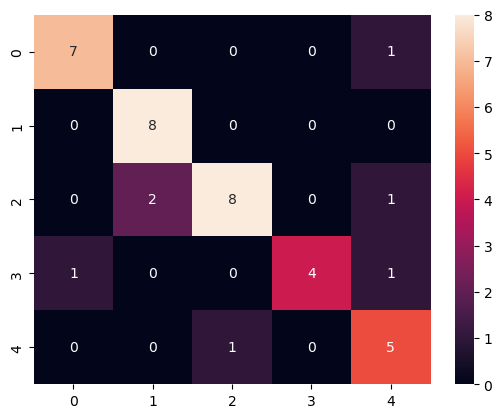

In [165]:
cm=confusion_matrix(y_test,best_clf.predict(X_test))


sns.heatmap(cm,annot=True)

In [166]:
class_dict

{'maria_sharapova': 0,
 'virat_kohli': 1,
 'lionel_messi': 2,
 'serena_williams': 3,
 'roger_federer': 4}

In [168]:
joblib.dump(best_clf,'saved_model.pkl')

['saved_model.pkl']

In [170]:
with open('class_dict.json','w') as f:
    f.write(json.dumps(class_dict))